In [1]:
import tarfile
import pandas as pd
import numpy as np
import pandas_profiling
from matplotlib import pyplot as plt
import pickle
from tqdm.notebook import tqdm


from surprise import Reader
from surprise import Dataset
from surprise.model_selection.split import train_test_split
from surprise.model_selection import cross_validate, GridSearchCV


from surprise import KNNBasic, KNNWithMeans
from surprise import SVDpp
from surprise import SVD
from surprise import accuracy
from surprise import SlopeOne
from surprise import NMF
from surprise import NormalPredictor
from surprise import KNNBaseline 
from surprise import KNNBasic 
from surprise import KNNWithMeans 
from surprise import KNNWithZScore 
from surprise import BaselineOnly 
from surprise import CoClustering

from community import community_louvain


/var/folders/ss/bwt02jls00d7gjr4fbxtn14m0000gn/T/ipykernel_26352/2720155385.py:4: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling


In [2]:
import networkx as nx
from pyvis.network import Network
net                = Network()

In [3]:
edges_info = pd.read_csv('LibraryThing/lthing_data/edges.txt', sep=" ", header=None)

In [4]:
# open file
file = tarfile.open('lthing_data.tar.gz')
  
# extracting file
file.extractall('LibraryThing')
  
file.close()

In [5]:
edges_info

,0,1
0,Rodo,anehan
1,Rodo,sevilemar
2,Rodo,dingsi
3,Rodo,slash
4,RelaxedReader,AnnRig
...,...,...
219785,Capfox,lampbane
219786,Capfox,maberry
219787,Capfox,raphinou
219788,Capfox,library1359


___

### Kartikeya's data pre-processing


In [6]:
with open('adjacency_matrix.pkl', 'rb') as f:
    adjacency_matrix = pickle.load(f)

In [7]:
with open('new_filtered_df.pkl', 'rb') as f:
    new_filtered_df = pickle.load(f)


In [8]:
new_filtered_df

,nhelpful,unixtime,work,user,stars,comment_embedding
0,0,1.332288e+09,73960,Elizabeth.Wong98,4.5,"[-145.84668869990855, 60.59739338606596, 134.0..."
1,0,1.253405e+09,69413,rivkat,3.0,"[-2.4631957905367017, -21.9402019623667, 28.03..."
2,0,1.299888e+09,9523995,suz.haugland,4.0,"[-134.0713327061385, -4.0732360277324915, 222...."
4,0,1.329005e+09,11243828,CandyH,4.0,"[-38.956352949142456, 26.277297034859657, 21.7..."
5,0,1.278893e+09,9071901,miyurose,2.0,"[-13.054501704871655, 23.149324550293386, 29.8..."
...,...,...,...,...,...,...
1707060,0,1.248048e+09,2129329,heidijane,4.0,"[-10.742771357297897, 6.943109214305878, 10.36..."
1707061,0,1.373242e+09,11234213,wyvernfriend,3.5,"[-60.59554514568299, 2.6624271483160555, 30.68..."
1707062,0,1.330906e+09,87328,bookwormteri,2.0,"[-4.7271137102507055, 6.203029625117779, 69.68..."
1707066,0,1.364688e+09,11749693,AmyMacEvilly,5.0,"[-50.50408464670181, 32.07558064162731, 81.494..."


In [9]:
df_users = set(new_filtered_df.user)
edges_users = set(pd.concat([edges_info[0], edges_info[1]]))

In [10]:
len(edges_users)

65946

In [11]:
len(df_users)

25275

In [12]:
len(df_users.intersection(edges_users))

25275

In [13]:
common_users = df_users.intersection(edges_users)

In [14]:
len(common_users)

25275

### Martin's data pre-processing

In [15]:
G = nx.Graph()
G.add_nodes_from(common_users)

In [16]:
len(G.nodes)

25275

In [17]:
for i, j in edges_info.values:
    if i in common_users and j in common_users:
        G.add_edge(i, j)
     

In [18]:
nx.is_connected(G)

False

There a lot of subgraphs because the network is not connected.

In [19]:
for i in [len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]:
    if i > 3:
        print("size: ", i)

size:  18161
size:  68
size:  56
size:  54
size:  46
size:  41
size:  24
size:  17
size:  17
size:  16
size:  15
size:  14
size:  13
size:  12
size:  12
size:  12
size:  12
size:  11
size:  10
size:  10
size:  9
size:  9
size:  9
size:  9
size:  8
size:  8
size:  8
size:  8
size:  8
size:  8
size:  7
size:  7
size:  7
size:  7
size:  7
size:  6
size:  6
size:  6
size:  6
size:  6
size:  6
size:  6
size:  5
size:  5
size:  5
size:  5
size:  5
size:  5
size:  5
size:  5
size:  5
size:  5
size:  4
size:  4
size:  4
size:  4
size:  4
size:  4
size:  4
size:  4
size:  4
size:  4
size:  4
size:  4
size:  4
size:  4
size:  4
size:  4
size:  4
size:  4
size:  4
size:  4
size:  4
size:  4
size:  4
size:  4
size:  4
size:  4
size:  4
size:  4
size:  4


We kept the largest subgraph for simplicity. To ensure that the other algorithms will not run into issues and not have to add global nodes to make the entire graph connected.

In [20]:
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
G_m = G.subgraph(Gcc[0])

In [21]:
# users from the largest subgraph
users_main = set(G_m.nodes)

In [22]:
len(common_users)

25275

In [23]:
len(users_main) 

18161

There are less users when we filter out the subgraphs, about 7k less

In [24]:
len(common_users) - len(users_main) 

7114

Filter out the dataframe provided by Kartikeya and keep only the entries that contain users found in the largest subgraph

In [25]:
main_df = new_filtered_df[new_filtered_df['user'].isin(users_main)]


In [26]:
main_df

,nhelpful,unixtime,work,user,stars,comment_embedding
0,0,1.332288e+09,73960,Elizabeth.Wong98,4.5,"[-145.84668869990855, 60.59739338606596, 134.0..."
1,0,1.253405e+09,69413,rivkat,3.0,"[-2.4631957905367017, -21.9402019623667, 28.03..."
2,0,1.299888e+09,9523995,suz.haugland,4.0,"[-134.0713327061385, -4.0732360277324915, 222...."
4,0,1.329005e+09,11243828,CandyH,4.0,"[-38.956352949142456, 26.277297034859657, 21.7..."
5,0,1.278893e+09,9071901,miyurose,2.0,"[-13.054501704871655, 23.149324550293386, 29.8..."
...,...,...,...,...,...,...
1707060,0,1.248048e+09,2129329,heidijane,4.0,"[-10.742771357297897, 6.943109214305878, 10.36..."
1707061,0,1.373242e+09,11234213,wyvernfriend,3.5,"[-60.59554514568299, 2.6624271483160555, 30.68..."
1707062,0,1.330906e+09,87328,bookwormteri,2.0,"[-4.7271137102507055, 6.203029625117779, 69.68..."
1707066,0,1.364688e+09,11749693,AmyMacEvilly,5.0,"[-50.50408464670181, 32.07558064162731, 81.494..."


In [27]:
len(new_filtered_df)

938898

In [28]:
len(main_df)

836543

We filtered out about 100k entries from the dataframe by filtering out the data and making sure our graph is connected

In [29]:
len(new_filtered_df) - len(main_df)

102355

In [30]:
with open('main_df.pkl', 'wb') as f:
    pickle.dump(main_df, f)

Created an adjacency list in case team needs it

In [31]:
user_to_index = {}
for i, user in enumerate(users_main):
    user_to_index[user] = i
    
index_to_user = {}
for i, user in enumerate(users_main):
    index_to_user[i] = user

In [32]:
adj_ls = np.zeros([len(users_main), len(users_main)])
for i, j in G_m.edges:
    if i in users_main and j in users_main:
        u, v = user_to_index[i], user_to_index[j]
        adj_ls[u][v] = adj_ls[v][u] = 1

In [33]:
with open('adj_ls.pkl', 'wb') as f:
    pickle.dump(adj_ls, f)

---

___

# Start Graph Recomendation System using network of users

In [34]:
with open('main_df.pkl', 'rb') as f:
    main_df = pickle.load(f)

In [35]:
{key: user_to_index[key] for key in list(user_to_index.keys())[:10]}

{'roblong': 0,
 'lexport': 1,
 'hockeygalscores': 2,
 'Munchkinelf': 3,
 'Kelpp': 4,
 'RobertBast': 5,
 'lovelyluck': 6,
 'maxairborne': 7,
 'rdurie': 8,
 'Truly_Bookish': 9}

In [36]:
{key: index_to_user[key] for key in list(index_to_user.keys())[:10]}

{0: 'roblong',
 1: 'lexport',
 2: 'hockeygalscores',
 3: 'Munchkinelf',
 4: 'Kelpp',
 5: 'RobertBast',
 6: 'lovelyluck',
 7: 'maxairborne',
 8: 'rdurie',
 9: 'Truly_Bookish'}

In [37]:
dispersion = nx.dispersion(G_m)


In [38]:
# collect all the values of dispersion
dispersion_values = []

for d in dispersion.values():
    for value in d.values():
        dispersion_values.append(value)
        
        


show the distribution of dispersion values

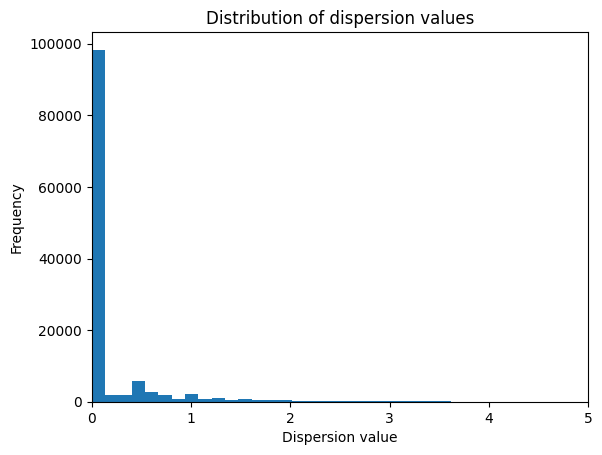

In [39]:
plt.hist(dispersion_values, bins=300)
plt.xlabel('Dispersion value')
plt.ylabel('Frequency')
plt.title('Distribution of dispersion values')
plt.xlim([0, 5])
plt.show()

Dispersion might not be a good measurement to use because a two users in a community might not have a dispersion value for one another. 

In [40]:
degree = dict(nx.degree(G_m))

In [41]:
# Get degree distribution values
degree_values = list(degree.values())
print('Degree range:', min(degree_values), '-', max(degree_values))

Degree range: 1 - 1704


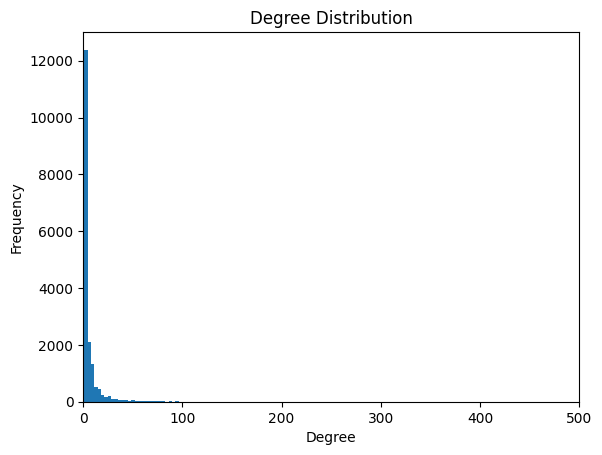

In [42]:
# Create histogram
plt.hist(degree_values, bins=500)
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution')
plt.xlim([0, 500])
plt.show()

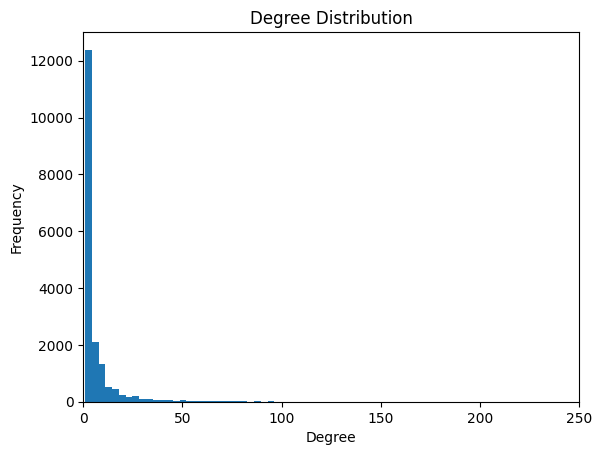

In [43]:
# Create histogram
plt.hist(degree_values, bins=500)
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution')
plt.xlim([0, 250])
plt.show()

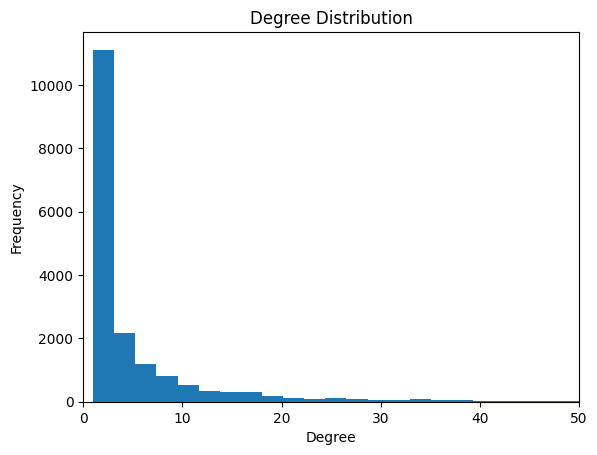

In [44]:
# Create histogram
plt.hist(degree_values, bins=800)
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution')
plt.xlim([0, 50])
plt.show()

An additional measurement to determine how important a node is, we will use eigenvector. The eigenvector measures the importance of a node based on the importance of its neighbors.Nodes with a high eigenvector centrality are thought to be more important because they are able to spread influence throughout the network.

In [45]:
eigenvector_cent = nx.eigenvector_centrality(G_m)


In [46]:
# Get degree distribution values
eigen_values = list(eigenvector_cent.values())
print('Degree range:', min(eigen_values), '-', max(eigen_values))

Degree range: 4.3534024169324535e-17 - 0.4197863120410799


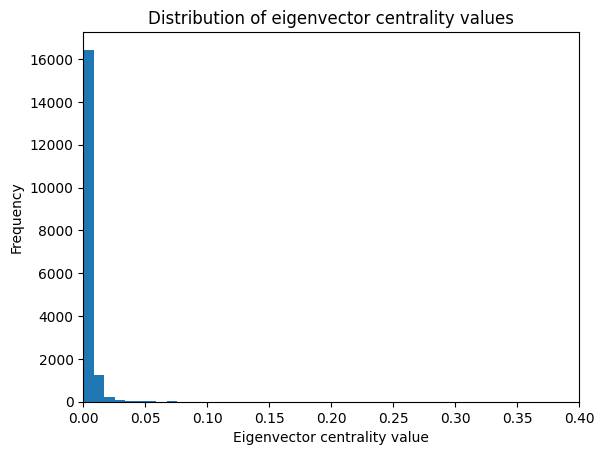

In [47]:
# Create histogram
plt.hist(eigen_values, bins=50)
plt.xlabel('Eigenvector centrality value')
plt.ylabel('Frequency')
plt.title('Distribution of eigenvector centrality values')
plt.xlim([0, .4])
plt.show()


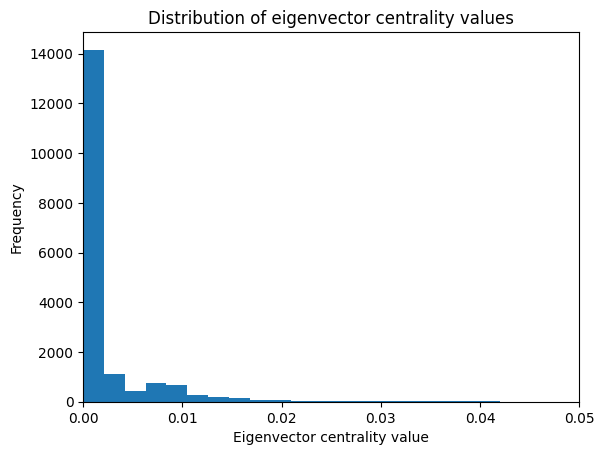

In [48]:
# Create histogram
plt.hist(eigen_values, bins=200)
plt.xlabel('Eigenvector centrality value')
plt.ylabel('Frequency')
plt.title('Distribution of eigenvector centrality values')
plt.xlim([0, .05])
plt.show()


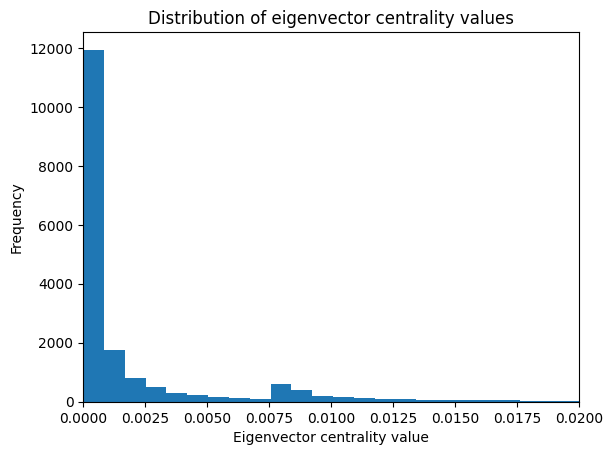

In [49]:
# Create histogram
plt.hist(eigen_values, bins=500)
plt.xlabel('Eigenvector centrality value')
plt.ylabel('Frequency')
plt.title('Distribution of eigenvector centrality values')
plt.xlim([0, .02])
plt.show()


To take into account how many shortest paths pass through a node and have a different measurement to determine the importance of a node in the graph we will use betweenness centrality. However, here I used subgraphs to make things faster because using the whole graph took too long. I broke down the graph by determining the centraility of a node by using a subggraph of its neighbors. 

In [50]:
betweenness_centralities = {}
for node in tqdm(G_m.nodes()):
    neighbors = G_m.neighbors(node)
    subgraph = G_m.subgraph(neighbors)
    betweenness_centrality = nx.betweenness_centrality(subgraph)
    for k, v in betweenness_centrality.items():
        if k not in betweenness_centralities:
            betweenness_centralities[k] = 0
        betweenness_centralities[k] += v

  0%|          | 0/18161 [00:00<?, ?it/s]

In [51]:
# Get degree distribution values
between_values = list(betweenness_centralities.values())
print('Degree range:', min(between_values), '-', max(between_values))

Degree range: 0.0 - 164.87687793353558


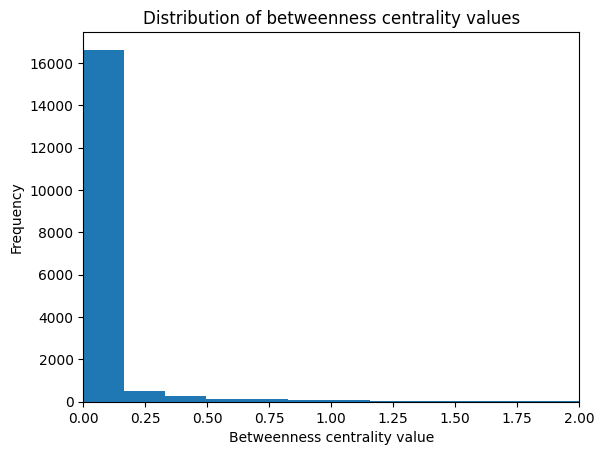

In [52]:
# Create histogram
plt.hist(between_values, bins=1000)
plt.xlabel('Betweenness centrality value')
plt.ylabel('Frequency')
plt.title('Distribution of betweenness centrality values')
plt.xlim([0, 2])
plt.show()


To identify communities within the graph we will use the Louvain Community Detection algorithm. This will allow us to quickly generate a group of similar users when generating recommendations. 

In [53]:
louvian_com = nx.community.louvain_communities(G_m)

In [54]:
type(louvian_com)

list

In [55]:
# will be useful for find the community with a username
louvian_dict = {node: i for i, comm in enumerate(louvian_com) for node in comm}

In [56]:
import community

In [57]:
partition = community.best_partition(G_m)

### Generate a dataframe to use for model creation

In [58]:
main_df

,nhelpful,unixtime,work,user,stars,comment_embedding
0,0,1.332288e+09,73960,Elizabeth.Wong98,4.5,"[-145.84668869990855, 60.59739338606596, 134.0..."
1,0,1.253405e+09,69413,rivkat,3.0,"[-2.4631957905367017, -21.9402019623667, 28.03..."
2,0,1.299888e+09,9523995,suz.haugland,4.0,"[-134.0713327061385, -4.0732360277324915, 222...."
4,0,1.329005e+09,11243828,CandyH,4.0,"[-38.956352949142456, 26.277297034859657, 21.7..."
5,0,1.278893e+09,9071901,miyurose,2.0,"[-13.054501704871655, 23.149324550293386, 29.8..."
...,...,...,...,...,...,...
1707060,0,1.248048e+09,2129329,heidijane,4.0,"[-10.742771357297897, 6.943109214305878, 10.36..."
1707061,0,1.373242e+09,11234213,wyvernfriend,3.5,"[-60.59554514568299, 2.6624271483160555, 30.68..."
1707062,0,1.330906e+09,87328,bookwormteri,2.0,"[-4.7271137102507055, 6.203029625117779, 69.68..."
1707066,0,1.364688e+09,11749693,AmyMacEvilly,5.0,"[-50.50408464670181, 32.07558064162731, 81.494..."


In [59]:
# turn book ids to int
main_df['work'] = main_df['work'].astype(int)

In [60]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 836543 entries, 0 to 1707069
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   nhelpful           836543 non-null  int64  
 1   unixtime           836543 non-null  float64
 2   work               836543 non-null  int64  
 3   user               836543 non-null  object 
 4   stars              836543 non-null  float64
 5   comment_embedding  836543 non-null  object 
dtypes: float64(2), int64(2), object(2)
memory usage: 44.7+ MB


In [61]:
main_df['user'] = main_df['user'].map(user_to_index)

In [62]:
main_df

,nhelpful,unixtime,work,user,stars,comment_embedding
0,0,1.332288e+09,73960,16707,4.5,"[-145.84668869990855, 60.59739338606596, 134.0..."
1,0,1.253405e+09,69413,7565,3.0,"[-2.4631957905367017, -21.9402019623667, 28.03..."
2,0,1.299888e+09,9523995,15771,4.0,"[-134.0713327061385, -4.0732360277324915, 222...."
4,0,1.329005e+09,11243828,15509,4.0,"[-38.956352949142456, 26.277297034859657, 21.7..."
5,0,1.278893e+09,9071901,11740,2.0,"[-13.054501704871655, 23.149324550293386, 29.8..."
...,...,...,...,...,...,...
1707060,0,1.248048e+09,2129329,12934,4.0,"[-10.742771357297897, 6.943109214305878, 10.36..."
1707061,0,1.373242e+09,11234213,5155,3.5,"[-60.59554514568299, 2.6624271483160555, 30.68..."
1707062,0,1.330906e+09,87328,2875,2.0,"[-4.7271137102507055, 6.203029625117779, 69.68..."
1707066,0,1.364688e+09,11749693,5129,5.0,"[-50.50408464670181, 32.07558064162731, 81.494..."


In [63]:
core = main_df[['work', 'user', 'stars']].copy()

In [64]:
core

,work,user,stars
0,73960,16707,4.5
1,69413,7565,3.0
2,9523995,15771,4.0
4,11243828,15509,4.0
5,9071901,11740,2.0
...,...,...,...
1707060,2129329,12934,4.0
1707061,11234213,5155,3.5
1707062,87328,2875,2.0
1707066,11749693,5129,5.0


### determine what model(s) to use

In [65]:
#used to visualize the training data and choose 
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

In [66]:
#view the rating distribution
data = core['stars'].value_counts().sort_index(ascending=False)
trace = go.Bar(x = data.index,
               text = ['{:.1f} %'.format(val) for val in (data.values / core.shape[0] * 100)],
               textposition = 'auto',
               textfont = dict(color = '#000000'),
               y = data.values,
               )
# Create layout
layout = dict(title = 'Distribution Of {} book-ratings'.format(core.shape[0]),
              xaxis = dict(title = 'Rating'),
              yaxis = dict(title = 'Count'))
# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [67]:
#get a smaller sample to test with different factorization algorighthms
min_book_ratings =100
filter_books = core['work'].value_counts() > min_book_ratings
filter_books = filter_books[filter_books].index.tolist()

min_user_ratings = 50
filter_users = core['user'].value_counts() > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

df_new = core[(core['work'].isin(filter_books)) & (core['user'].isin(filter_users))]
print('The original data frame shape:\t{}'.format(core.shape))
print('The new data frame shape:\t{}'.format(df_new.shape))

The original data frame shape:	(836543, 3)
The new data frame shape:	(51100, 3)


In [68]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df_new[['work', 'user', 'stars']], reader)


In [69]:
benchmark = []
# Iterate over all algorithms to identify which one is the best using the smaller sample from the
# training data
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=5, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')

/var/folders/ss/bwt02jls00d7gjr4fbxtn14m0000gn/T/ipykernel_26352/2737206286.py:10: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/ss/bwt02jls00d7gjr4fbxtn14m0000gn/T/ipykernel_26352/2737206286.py:10: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/ss/bwt02jls00d7gjr4fbxtn14m0000gn/T/ipykernel_26352/2737206286.py:10: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/ss/bwt02jls00d7gjr4fbxtn14m0000gn/T/ipykernel_26352/2737206286.py:10: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/ss/bwt02jls00d7gjr4fbxtn14m0000gn/T/ipykernel_26352/2737206286.py:10: FutureWarning:

The series.append method 

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


/var/folders/ss/bwt02jls00d7gjr4fbxtn14m0000gn/T/ipykernel_26352/2737206286.py:10: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


/var/folders/ss/bwt02jls00d7gjr4fbxtn14m0000gn/T/ipykernel_26352/2737206286.py:10: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


/var/folders/ss/bwt02jls00d7gjr4fbxtn14m0000gn/T/ipykernel_26352/2737206286.py:10: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


/var/folders/ss/bwt02jls00d7gjr4fbxtn14m0000gn/T/ipykernel_26352/2737206286.py:10: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


/var/folders/ss/bwt02jls00d7gjr4fbxtn14m0000gn/T/ipykernel_26352/2737206286.py:10: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/ss/bwt02jls00d7gjr4fbxtn14m0000gn/T/ipykernel_26352/2737206286.py:10: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,test_rmse,fit_time,test_time
Algorithm,,,
SVDpp,0.865133,2.724662,0.535646
BaselineOnly,0.868552,0.025941,0.014831
SVD,0.874875,0.191850,0.047861
KNNBaseline,0.876193,0.034494,0.207938
KNNWithMeans,0.878003,0.016613,0.185482
SlopeOne,0.880278,0.192019,0.402802
KNNWithZScore,0.882149,0.026333,0.187055
KNNBasic,0.922476,0.013116,0.166374
CoClustering,0.925734,0.284044,0.037266


Based on this, we can see that SVDpp, BaselineOnly, and SVD are the top models. SVDpp might take too long with this big of a dataset

---

# Build the models to potentially use for generating predictions and recommendations

In [70]:
reader = Reader(rating_scale=(1, 10))  #invoke reader instance of surprise library
data=Dataset.load_from_df(core,reader) #load dataset into Surprise datastructure Dataset

In [71]:
param_grid = {'bsl_options': {'method':  ['als', 'sgd'],
             'reg_all': [.02, .03, .05],
             'n_epochs': [25, 30, 35] }}

gs = GridSearchCV(BaselineOnly, param_grid, measures=['rmse','mae'], cv=3, n_jobs=-1, joblib_verbose=10) 
gs.fit(data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done  41 out of  54 | elapsed:   26.3s remaining:    8.3s
[Parallel(n_jobs=-1)]: Done  47 out of  54 | elapsed:   29.7s remaining:    4.4s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   33.6s finished


In [72]:
# best RMSE score
print(gs.best_score['rmse'])
# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.8627720440705043
{'bsl_options': {'method': 'sgd', 'reg_all': 0.02, 'n_epochs': 30}}


In [73]:
base_alg = gs.best_estimator['rmse']

In [74]:
base_alg.fit(data.build_full_trainset())

Estimating biases using sgd...


---

In [75]:
reader = Reader(rating_scale=(1, 10))  #invoke reader instance of surprise library
data=Dataset.load_from_df(core,reader) #load dataset into Surprise datastructure Dataset
param_grid = {'n_factors': [1, 3, 5],
              'reg_all': [ .05, 0.1, .2],
              'n_epochs': [20, 25, 35]
              }

gs = GridSearchCV(SVD, param_grid, measures=['rmse','mae'], cv=5, n_jobs=-1, joblib_verbose=10) 
gs.fit(data)
# best RMSE score
print(gs.best_score['rmse'])
# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])
# We can now use the algorithm that yields the best rmse:
svd = gs.best_estimator['rmse']
svd.fit(data.build_full_trainset())

#You may use this instead of some parts of the following section, to make predictions for the unseen data (i.e. all the missing ratings)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   39.2s
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   46.8s
[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   55.9s
[Parallel(n_jobs=-1)]: Done 108 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 130 out of 135 | elapsed:  1.3min remaining:    3.0s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:  1.3min finished


0.859516678275484
{'n_factors': 1, 'reg_all': 0.05, 'n_epochs': 35}


In [76]:
reader = Reader(rating_scale=(1, 10))  #invoke reader instance of surprise library
data=Dataset.load_from_df(core,reader) #load dataset into Surprise datastructure Dataset
param_grid = {'n_factors': [1, 3, 5],
              'reg_all': [ .05, 0.1, .2],
              'n_epochs': [20, 25, 35]
              }

gs = GridSearchCV(SVDpp, param_grid, measures=['rmse','mae'], cv=5, n_jobs=-1, joblib_verbose=10) 
gs.fit(data)
# best RMSE score
print(gs.best_score['rmse'])
# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])
# We can now use the algorithm that yields the best rmse:
svdpp = gs.best_estimator['rmse']
svdpp.fit(data.build_full_trainset())

#You may use this instead of some parts of the following section, to make predictions for the unseen data (i.e. all the missing ratings)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   42.3s
[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   56.3s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 108 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 130 out of 135 | elapsed:  2.9min remaining:    6.6s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:  3.0min finished


0.8599129006137373
{'n_factors': 1, 'reg_all': 0.05, 'n_epochs': 25}


# Prep for recommendatio system

In [77]:
grouped = main_df.groupby('user')['work'].apply(list).reset_index(name='book_list')


In [78]:
grouped

,user,book_list
0,0,"[262571, 12593516, 2853402, 2965719, 7595267, ..."
1,1,"[8253778, 115295, 1475, 32411, 6269624, 175396..."
2,2,"[2398550, 1858670, 579902, 3790953, 5173, 3577..."
3,3,"[12757788, 11844613, 13460635]"
4,4,"[2788894, 1402407]"
...,...,...
18156,18156,"[168956, 5161, 4647, 11698165, 278652, 37306, ..."
18157,18157,"[14146148, 13897879]"
18158,18158,"[619492, 85188, 9627799, 3123767, 9149546, 657..."
18159,18159,"[553055, 3540069, 342805, 199021, 2966978, 316..."


Using louvian, i will generate top similar users

In [79]:
def avg_importance(importance_measurements):
    denominator = len(importance_measurements)
    if(denominator == 0):
        print("Denominator is 0")
        return
    numerator = 0
    for i in importance_measurements:
        numerator += i
    
    return (numerator/denominator)
        

In [80]:
# def get_importance(ref_user, neighbor, sig_measures):
#     m = []
#     for d in sig_measures:
#         if type(d)  == dict:
#             if (ref_user in d) and neighbor in d[ref_user]):
#                 print('here')
#                 m.append(d[ref_user][neighbor])
#         else:
#              m.append(d[ref_user])
        
#     return avg_importance(m)

In [81]:
def get_importance(ref_user, sig_measurements):
    denominator = len(sig_measurements)
    if(denominator == 0):
        print("Denominator is 0")
        return
    numerator = 0
    for i in sig_measurements:
        numerator += i[ref_user]
    
    return (numerator/denominator)

In [82]:
def get_top_neighbors(ref_user, communities, com_dict, sig_measurements):
    neighbors = communities[com_dict[ref_user]]
    cap = len(neighbors)
    if(cap > 5):
        cap = 5
    
    imp_dict = {}
    for i in neighbors:
        imp_dict[i] = get_importance(i, sig_measurements)
    
    imp_dict = sorted(imp_dict.items(), key=lambda x: x[1], reverse=True)
    top_users = [x[0] for x in imp_dict[:cap]]
    
    
    return top_users
    

In [83]:
def get_anti_book_set(ref_user, top_users, data):
    books_ls = []
    for i in top_users:
        books = data[data['user'] == user_to_index[i]]['book_list'].iloc[0]
        books_ls.extend(books)
    
    return (set(books_ls) - set(data[data['user'] == user_to_index[ref_user]]['book_list'].iloc[0]))

In [84]:
# gets the top books for recommendations
def get_top_books(ref_user, rec_amount, top_users, data, model):
    books_ls = get_anti_book_set(ref_user, top_users, data)
    cap = len(books_ls)
    if(cap > rec_amount):
        cap = rec_amount
    book_dict = {}
    for b in books_ls:
        book_dict[b] = model.predict(ref_user, b).est
#         book_dict[b] = model.predict(ref_user, b, verbose=True).est


        
    top_books = sorted(book_dict.items(), key=lambda x: x[1], reverse=True)[:cap]

    
    return top_books

In [85]:
# genrates recommendations book recommendations
def get_recommendations(ref_user, G, model, data, communities, com_dict, sig_measurements, rec_amount):
    top_users = get_top_neighbors(ref_user, communities, com_dict, sig_measurements)
    top_books = get_top_books(ref_user, rec_amount,top_users, data, model)
    
    return top_books
    

In [86]:
def print_recommendations(recommendations):
    for b, pred in recomendations:
        print('Book ID: {:<10}Predicted Rating: {:.3f}'.format(b, pred))

# Recommendation System using Social Network Graph

In [87]:
# measurements to use for sorting top neighbors
measurements = [betweenness_centralities, degree, eigenvector_cent]
#user to generate recommendations for
ref_user = 'mmignano11'
#gets top 5 recommendations
recommendations = get_recommendations(ref_user, G_m, base_alg, grouped, louvian_com, louvian_dict, measurements, 5)

In [88]:
recommendations

[(17927, 4.92563583152558),
 (15657, 4.580572493255862),
 (4178, 4.506160825588684),
 (16482, 4.43204570428034),
 (4907, 4.430869440724898)]

In [89]:
measurements = [betweenness_centralities, degree, eigenvector_cent]
ref_user = 'mmignano11'
recomendations = get_recommendations(ref_user, G_m, svdpp, grouped, louvian_com, louvian_dict, measurements, 5)
print_recommendations(recomendations)

Book ID: 17927     Predicted Rating: 4.899
Book ID: 15657     Predicted Rating: 4.552
Book ID: 4178      Predicted Rating: 4.510
Book ID: 4907      Predicted Rating: 4.477
Book ID: 6071      Predicted Rating: 4.470


In [90]:
print_recommendations(recomendations)

Book ID: 17927     Predicted Rating: 4.899
Book ID: 15657     Predicted Rating: 4.552
Book ID: 4178      Predicted Rating: 4.510
Book ID: 4907      Predicted Rating: 4.477
Book ID: 6071      Predicted Rating: 4.470


In [91]:
measurements = [betweenness_centralities, degree, eigenvector_cent]
ref_user = 'mmignano11'
recomendations = get_recommendations(ref_user, G_m, svd, grouped, louvian_com, louvian_dict, measurements, 5)
print_recommendations(recomendations)

Book ID: 17927     Predicted Rating: 4.885
Book ID: 15657     Predicted Rating: 4.554
Book ID: 4178      Predicted Rating: 4.504
Book ID: 4907      Predicted Rating: 4.476
Book ID: 6071      Predicted Rating: 4.471


When determining which model to use for making predictions, we dermined the top algorithms to use were SVDpp (1), BaselineOnly (2), and in last place SVD (3). When we check for recommendations using these three different models, we can see that SVDpp and BaselineOnly have very similar outputs with the books recommended. 

In [92]:
print(list(users_main)[:10])


['roblong', 'lexport', 'hockeygalscores', 'Munchkinelf', 'Kelpp', 'RobertBast', 'lovelyluck', 'maxairborne', 'rdurie', 'Truly_Bookish']


In [93]:
# measurements to use for sorting top neighbors
measurements = [betweenness_centralities, degree, eigenvector_cent]

count = 0

b_ls = []
#for first 10 users
for i in users_main:
    if count < 10:
        #user to generate recommendations for
        ref_user = i
        print("User: ", ref_user)
        #gets top 5 recommendations using each model
        print("SVDpp")
        recomendations = get_recommendations(ref_user, G_m, svdpp, grouped, louvian_com, louvian_dict, measurements, 5)
        print_recommendations(recomendations)
        b_ls.append([b[0] for b in recomendations])

        print("\n\n")
        count += 1
    else:
        break

User:  roblong
SVDpp
Book ID: 4178      Predicted Rating: 4.510
Book ID: 8247      Predicted Rating: 4.332
Book ID: 4051      Predicted Rating: 4.331
Book ID: 16279     Predicted Rating: 4.324
Book ID: 995       Predicted Rating: 4.247



User:  lexport
SVDpp
Book ID: 11178     Predicted Rating: 4.850
Book ID: 17826     Predicted Rating: 4.782
Book ID: 724       Predicted Rating: 4.751
Book ID: 1833      Predicted Rating: 4.706
Book ID: 10563     Predicted Rating: 4.703



User:  hockeygalscores
SVDpp
Book ID: 16222     Predicted Rating: 4.810
Book ID: 12466     Predicted Rating: 4.464
Book ID: 4279      Predicted Rating: 4.340
Book ID: 8234      Predicted Rating: 4.289
Book ID: 2144      Predicted Rating: 4.283



User:  Munchkinelf
SVDpp
Book ID: 6028      Predicted Rating: 4.123
Book ID: 5811      Predicted Rating: 4.109
Book ID: 6099      Predicted Rating: 3.976
Book ID: 1472      Predicted Rating: 3.969
Book ID: 1864      Predicted Rating: 3.941



User:  Kelpp
SVDpp
Book ID: 1117

In [94]:
flattened_list = [item for sublist in b_ls for item in sublist]

In [95]:
print('Number of unique books recommended to 10 users: ', len(set(flattened_list)))

Number of unique books recommended to 10 users:  32


In [96]:
# measurements to use for sorting top neighbors
measurements = [betweenness_centralities, degree, eigenvector_cent]

count = 0

b_ls = []
#for first 10 users
for i in users_main:
    if count < 100:
        #user to generate recommendations for
        ref_user = i
        print("User: ", ref_user)
        #gets top 5 recommendations using each model

        recomendations = get_recommendations(ref_user, G_m, svdpp, grouped, louvian_com, louvian_dict, measurements, 5)

        b_ls.append([b[0] for b in recomendations])

            
        

        recomendations = get_recommendations(ref_user, G_m, base_alg, grouped, louvian_com, louvian_dict, measurements, 5)

        b_ls.append([b[0] for b in recomendations])
        

        recomendations = get_recommendations(ref_user, G_m, svd, grouped, louvian_com, louvian_dict, measurements, 5)

        b_ls.append([b[0] for b in recomendations])
        count += 1
    else:
        break

User:  roblong
User:  lexport
User:  hockeygalscores
User:  Munchkinelf
User:  Kelpp
User:  RobertBast
User:  lovelyluck
User:  maxairborne
User:  rdurie
User:  Truly_Bookish
User:  pageboy
User:  clairep
User:  cubeshelves
User:  PreetiGupta
User:  wordnat
User:  PSCottier
User:  speljamr
User:  tsinandali
User:  cflorente
User:  khixson1
User:  jbvm
User:  stefano
User:  mrellis64
User:  bhall
User:  katelisim
User:  eddiemerkel
User:  RavenousReaders
User:  thorswitch
User:  bigcurlyloz
User:  sixbucksamonkey
User:  Thresher
User:  prophetbob
User:  ANeumann
User:  satya8
User:  Gateaupain
User:  lilwatchergirl
User:  spartyliblover
User:  marielovesbooks
User:  anikaschihuahuas
User:  outontheshelves
User:  donnambr
User:  Nazgullie
User:  Brian242
User:  anniegrace720
User:  jena2
User:  denmoir
User:  mkjones
User:  cierramarinko
User:  odrini
User:  tomray
User:  bgriff
User:  wbarker
User:  kathrynnd
User:  tbert204
User:  bethers1919
User:  lisagibson
User:  bunny0055
User:  R

In [97]:
flattened_list = [item for sublist in b_ls for item in sublist]

In [98]:
print('Number of unique books recommended to 100 users: ', len(set(flattened_list)))

Number of unique books recommended to 100 users:  104
